In [3]:
import os
import torch
import numpy as np

# CODE FILES HERE
from models.tdcvae.tdcvae import Encoder, Decoder, TD_Cvae, PATH
from solver import Solver
from dataloader import DataLoader
from preprocessing import Preprocessing
from plot import plot_losses, plot_gaussian_distributions, plot_rl_kl, plot_latent_space,\
plot_latent_manifold, plot_prepro_params_distribution, plot_prepro_params_distribution_categories,\
plot_faces_grid, plot_faces_samples_grid

# SETTINGS HERE
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # to see the CUDA stack
%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
# supress cluttering warnings in solutions
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# setting device on GPU if available, else CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cpu



In [5]:
# Choose the dataset and tune hyperparameters here!
dataset = "MNIST"

batch_size = 128
optimizer = torch.optim.Adam

if dataset == "MNIST":
    epochs = 3
    hidden_dim_enc = 500
    z_dim = 2
    beta = 1 if z_dim == 2 else 1
    lr_scheduler = torch.optim.lr_scheduler.StepLR
    step_config = {
        "step_size" : 200,
        "gamma" : 0.1 # or 0.75
    }
    optim_config = {
        "lr": 1e-3,
        "weight_decay": None
    }
    thetas = {
        "theta_1": [-180, 180],
        "theta_2": [-30, 30]
    }
    scales = {
        "scale_1": [0.5, 0.9],
        "scale_2": [0.2, 0.4]
    }

In [6]:
data_loader = DataLoader(PATH, batch_size, dataset, z_dim)
prepro = Preprocessing(data_loader, thetas=thetas)
model = TD_Cvae(data_loader.input_dim, hidden_dim_enc, data_loader.input_dim, z_dim)
solver = Solver(model, data_loader, optimizer, z_dim, epochs, beta, step_config, optim_config, lr_scheduler=lr_scheduler, tdcvae_mode=True, prepro=prepro)
solver.main()

+++++ START RUN | saved files in ../results/tdcvae/MNIST_z=2_60 +++++
====> Epoch: 1 train set loss avg: 164.5452
====> Test set loss avg: 139.1388
95.04 seconds for epoch 1
====> Epoch: 2 train set loss avg: 130.2391
====> Test set loss avg: 127.0896
96.29 seconds for epoch 2
====> Epoch: 3 train set loss avg: 123.5651
====> Test set loss avg: 120.9500
102.85 seconds for epoch 3
+++++ RUN IS FINISHED +++++


In [ ]:
# solver = torch.load("../results/saved_models/model_TD_CVAE_MNIST_train_loss=92.18_z=2.pt", map_location='cpu')
# solver.model.eval()

In [ ]:
# Plotting train and test losses for all epochs
plot_losses(solver)

In [ ]:
# Plotting the gaussian of z space and some metrics about the space
plot_gaussian_distributions(solver)

In [ ]:
# Monitoring the reconstruction loss (likelihood lower bound) and KL divergence
DEBUG = 0
if DEBUG:
    for epoch, train_loss, test_loss, rl, kl in zip(solver.train_loss_history["epochs"], \
        solver.train_loss_history["train_loss_acc"], solver.test_loss_history, \
        solver.train_loss_history["recon_loss_acc"], solver.train_loss_history["kl_diverg_acc"]):
        print("epoch: {}, train_loss: {:.2f}, test_loss: {:.2f}, recon. loss: {:.2f}, KL div.: {:.2f}".format(
            epoch, train_loss, test_loss, rl, kl))
        print("overfitting: {:.2f}".format(abs(test_loss-train_loss)))
plot_rl_kl(solver)

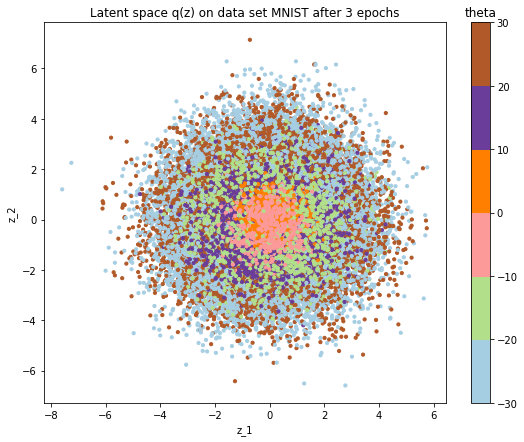

In [7]:
# visualize q(z) (latent space z)
if solver.z_dim == 2:
    for key in solver.prepro.prepro_params.keys():
        if key == "theta_diff" or key == "scale_diff":
            z_space_labels = np.repeat(solver.prepro.prepro_params[key], solver.data_loader.batch_size)
            if key == "theta_diff":
                ticks = np.arange(solver.prepro.theta_range_2[0], solver.prepro.theta_range_2[1]+1, 10).tolist()
            if key == "scale_diff":
                ticks = [round(0.1*x,1) for x in range(int(solver.prepro.scale_range_2[0]*10),\
                                                       int(solver.prepro.scale_range_2[1]+0.1)*10)]
            plot_latent_space(solver, solver.z_space, ticks, "z", key.split("_")[0], z_space_labels)
    if not solver.tdcvae_mode:
        if solver.data_loader.with_labels:
            plot_latent_space(solver, solver.z_space, var="z", labels=solver.data_labels)
        else:
            plot_latent_space(solver, solver.z_space, var="z")
else:
    print("Plot of latent space not possible as dimension of z is not 2")

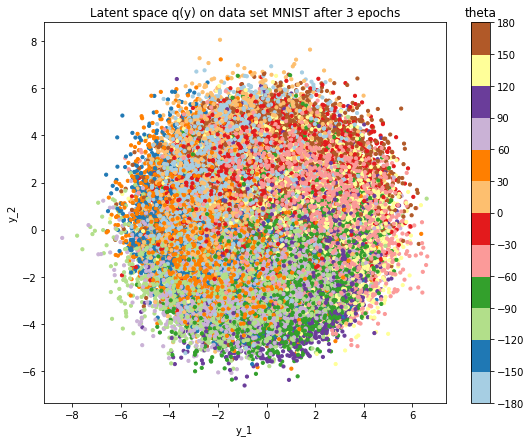

In [8]:
# visualize q(y)
if solver.z_dim == 2:
    for key in solver.prepro.prepro_params.keys():
        if key == "theta_1" or key == "scale_1":
            y_space_labels = np.repeat(solver.prepro.prepro_params[key], solver.data_loader.batch_size)
            if key == "theta_1":
                ticks = np.arange(solver.prepro.theta_range_1[0], solver.prepro.theta_range_1[1]+1, 30).tolist()
            if key == "scale_1":
                ticks = [round(0.1*x,1) for x in range(int(solver.prepro.scale_range_1[0]*10),\
                                                       int(solver.prepro.scale_range_1[1]+0.1)*10)]
            plot_latent_space(solver, solver.y_space, ticks, "y", key.split("_")[0], y_space_labels)
else:
    print("Plot of y space not possible as dimension of z is not 2")

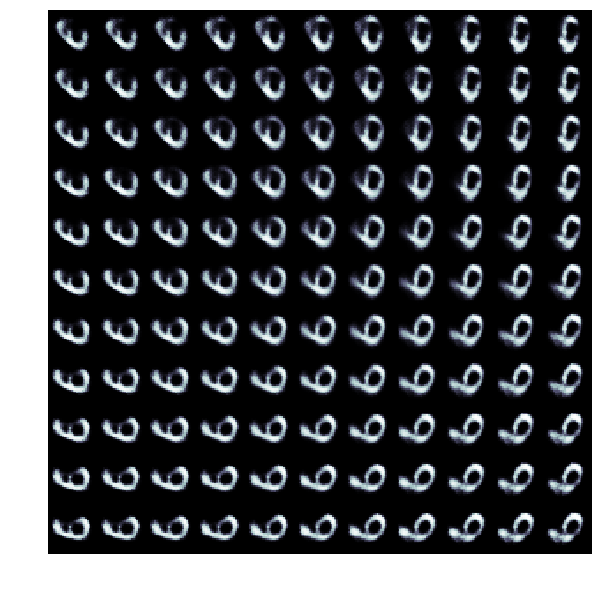

In [11]:
# Visualizations of learned data manifold for generative models with two-dimensional latent space
if solver.z_dim == 2:
    n = 11
    grid_x = np.linspace(-5, 5, n)
    grid_y = np.linspace(-5, 5, n)
    x_t = iter(solver.data_loader.train_loader).next()[0][0]
    x_t, _ = solver.prepro.preprocess_batch(x_t.view(1, *x_t.shape))
    plot_latent_manifold(solver, "bone", grid_x, grid_y, n, x_t=x_t)
else:
    print("Plot is not possible as dimension of z is not 2")

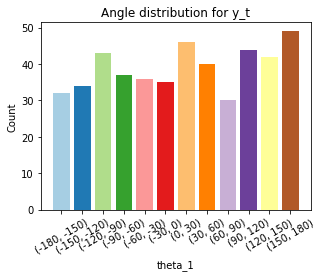

In [102]:
# Bar chart over the different theta_1/scale_1 used for y_t
if solver.z_dim == 2:
    for key in solver.prepro.prepro_params.keys():
        if key == "theta_1" or key == "scale_1":
            if key == "theta_1":
                xticks = np.arange(solver.prepro.theta_range_1[0], solver.prepro.theta_range_1[1]+1, 30).tolist()
                plot_prepro_params_distribution(solver, xticks, key, "Angle distribution for y_t", "Count")
            if key == "scale_1":
                xticks = [round(0.1*x,1) for x in range(int(solver.prepro.scale_range_1[0]*10),\
                                                       int(solver.prepro.scale_range_1[1]+0.1)*10)]
                plot_prepro_params_distribution(solver, xticks, key, "Scaling distribution for y_t", "Count")
else:
    print("Plot of y space not possible as dimension of z is not 2")

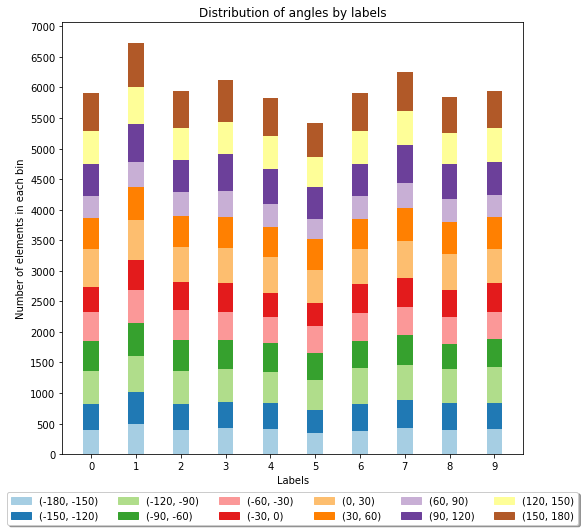

In [99]:
# distribution of angles/scales with categeries/classes of dataset as bins
if solver.z_dim == 2:
    for key in solver.prepro.prepro_params.keys():
        if key == "theta_1" or key == "scale_1":
            ytitle = "Number of elements in each bin"
            if key == "theta_1":
                xticks = np.arange(solver.prepro.theta_range_1[0], solver.prepro.theta_range_1[1]+1, 30).tolist()
                plot_prepro_params_distribution_categories(solver, xticks, key, "Distribution of angles by labels", ytitle)
            if key == "scale_1":
                xticks = [round(0.1*x,1) for x in range(int(solver.prepro.scale_range_1[0]*10),\
                                                       int(solver.prepro.scale_range_1[1]+0.1)*10)]
                plot_prepro_params_distribution_categories(solver, xticks, key, "Distribution of scales by labels", ytitle)
else:
    print("Plot of y space not possible as dimension of z is not 2")

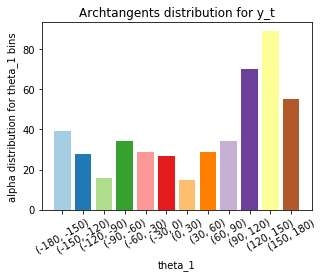

In [104]:
if solver.z_dim == 2:
    for key in solver.prepro.prepro_params.keys():
        if key == "theta_1":
            alphas = torch.atan2(torch.tensor(solver.y_space[:,0]-np.mean(solver.y_space[:,0])), torch.tensor(solver.y_space[:,1]-np.mean(solver.y_space[:,1])))/(2*np.pi)
            alphas = [round(x,2) for x in alphas.tolist()]
            alpha_ranges = np.around(np.linspace(np.min(alphas), np.max(alphas), 13), decimals=2)
            alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
            xticks = np.arange(solver.prepro.theta_range_1[0], solver.prepro.theta_range_1[1]+1, 30).tolist() # theta bins
            theta_alpha = list(zip(solver.prepro.prepro_params[key], alpha)) # each theta_1 and alpha_1 paired
            plot_prepro_params_distribution(solver, xticks, key, "Archtangents distribution for y_t", "alpha distribution for theta_1 bins", data=(theta_alpha, alpha_bins))
else:
    print("Plot of y space not possible as dimension of z is not 2")

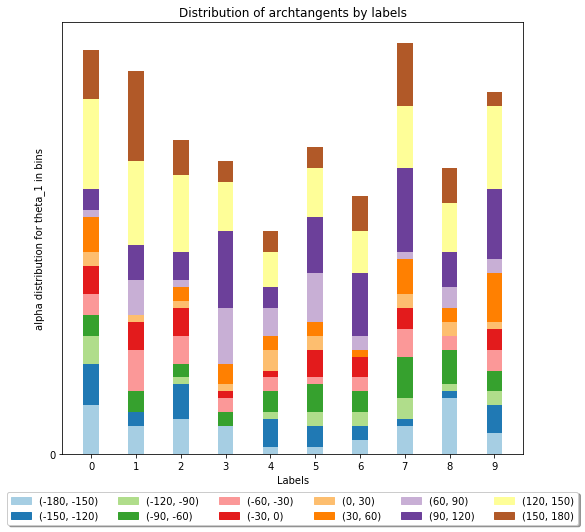

In [107]:
if solver.z_dim == 2:
    for key in solver.prepro.prepro_params.keys():
        if key == "theta_1":
            alphas = torch.atan2(torch.tensor(solver.y_space[:,0]-np.mean(solver.y_space[:,0])), torch.tensor(solver.y_space[:,1]-np.mean(solver.y_space[:,1])))/(2*np.pi)
            alphas = [round(x,2) for x in alphas.tolist()]
            alpha_ranges = np.around(np.linspace(np.min(alphas), np.max(alphas), 13), decimals=2)
            alpha_bins = list(zip(alpha_ranges[:-1], alpha_ranges[1:])) # alpha bins
            theta_bins = np.arange(solver.prepro.theta_range_1[0], solver.prepro.theta_range_1[1]+1, 30).tolist() # theta bins
            theta_alpha_label = list(zip(solver.prepro.prepro_params[key], alpha, solver.data_labels)) # each theta_1 and alpha_1 paired
            plot_prepro_params_distribution_categories(solver, theta_bins, key, "Distribution of archtangents by labels", "alpha distribution for theta_1 in bins", data=(theta_alpha_label, alpha_bins))
else:
    print("Plot of y space not possible as dimension of z is not 2")

In [19]:
last_train_loss = solver.train_loss_history["train_loss_acc"][-1]
torch.save(solver, solver.data_loader.result_dir + "/model_TD_CVAE_" + solver.data_loader.dataset + "_train_loss=" + "{0:.2f}".format(last_train_loss) + "_z=" + str(solver.z_dim) + ".pt")